#Load the Acticipate dataset from the pre-processed files

In [1]:
from torch.utils.data import Dataset
import cv2
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
import h5py
import numpy as np


class ActicipateDataset(Dataset):

    def __init__(self, is_batch = True):

        self.is_batch = is_batch
        self.head_positions = np.load('/content/drive/My Drive/head_key_points.npy')
        self.body_positions = np.load('/content/drive/My Drive/body_key_points.npy')
        self.ball_positions = np.load('/content/drive/My Drive/ball_key_points.npy')
        self.frame_info = np.load('/content/drive/My Drive/frame_info.npy')
        self.data_labels = np.load("/content/drive/My Drive/action_labels.npy")[:,1]
        # change the label of action class 12 to 0 for compatibility with cross entropy loss 
        self.data_labels[self.data_labels == 12] = 0


    def __len__(self):
        return self.frame_info.shape[0]

    def __getitem__(self, id):
        first, last = int(self.frame_info[id][0]), int(self.frame_info[id][1])+1
        if self.is_batch == True:
            if last >= first + 100:
                last = first + 100
                return self.head_positions[first:last], self.body_positions[first:last], self.ball_positions[first:last], self.data_labels[first:last]
            else: 
                pad = first + 100 - last
                return np.concatenate((self.head_positions[first:last], np.zeros((pad,12))), axis = 0), np.concatenate((self.body_positions[first:last], np.zeros((pad,12))), axis = 0), np.concatenate((self.ball_positions[first:last], np.zeros((pad,2))), axis = 0), np.concatenate((self.data_labels[first:last], np.ones((pad))*100), axis = 0)
        else:
            return self.head_positions[first:last], self.body_positions[first:last], self.ball_positions[first:last], self.data_labels[first:last]

# Acticipate dataset is called with set batch to False
# this means the sequences will not be truncated or padded to fit a batch
# the data loader has to run with a batch_size of 1

dataset = ActicipateDataset(False)
train_size = int(0.8 * dataset.__len__())
val_size = int(0.1 * dataset.__len__())
test_size = dataset.__len__() - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import numpy as np

import random
import math
import time

#Get the source embedding for the input

In [3]:
class get_embedding(nn.Module):
    def __init__(self, dropout):
        super().__init__()

        self.input2emb_body = nn.Linear(12,16)
        self.input2emb_head = nn.Linear(12,16)
        self.input2emb_ball = nn.Linear(2,16)
        self.input2emb_context = nn.Linear(32,16)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, in_head, in_body, in_ball):

        in_head = self.input2emb_head(in_head.float())
        in_body = self.input2emb_body(in_body.float())
        in_ball = self.input2emb_ball(in_ball.float())
        in_context = self.input2emb_context(torch.cat((in_head, in_ball), 1))
        embedding = torch.cat((in_body, in_context), 1)

        embedded = self.dropout(embedding)
      
        return embedded

#CNN model Implementation

In [4]:
class CNN_model(nn.Module):
    def __init__(self, emb_dim, hid_dim, out_dim, n_layers, kernel_size, dropout, max_length = 300):
        super().__init__()
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.input2emb = nn.Linear(32, emb_dim)
        self.convs1 = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2*hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        self.convs2 = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2*hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hid_dim, out_dim)
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).cuda()
        self.pos_embedding = nn.Embedding(max_length, emb_dim)

    def forward(self, embedded, conved1, conved2, pos):

        embedded = self.dropout(self.input2emb(embedded))
        embedded.unsqueeze_(1)
        batch_size = embedded.shape[0]
        pos = torch.LongTensor([pos]).unsqueeze(0).repeat(batch_size,1).cuda()
        pos_embedded = self.pos_embedding(pos)
        conv_input = (embedded.permute(0, 2, 1) + pos_embedded.permute(0,2,1) + conved1)

        for i, conv in enumerate(self.convs1):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))
            conved = F.glu(conved, dim = 1)            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            #set conv_input to conved for next loop iteration
            conv_input = conved

        conved1 = conved
        conv_input2 = (conved + conved2 + pos_embedded.permute(0,2,1)) 
        for i, conv in enumerate(self.convs2):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input2))
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)
            #apply residual connection
            conved = (conved + conv_input2) * self.scale
            #set conv_input to conved for next loop iteration
            conv_input2 = conved
        conved2 = conved
        prediction = self.fc_out(conved.permute(0,2,1).squeeze(1))

        return prediction, conved1, conved2


#Acticipate model is used to train the embeddings with the CNN model

In [5]:
class Anticipate_model(nn.Module):
      def __init__(self, embedding, cnn_model):
          super().__init__()
          
          self.embedding = embedding
          self.cnn_model = cnn_model
          self.hid_dim = self.cnn_model.hid_dim
          self.out_dim = self.cnn_model.out_dim

      def forward(self, inputs):
          head, body, ball = inputs
          batch_size = head.shape[0]
          seq_len = head.shape[1]
          outputs = torch.zeros(batch_size, seq_len, self.out_dim).cuda()
          conved1 = torch.zeros(batch_size, self.hid_dim, 1).cuda()
          conved2 = torch.zeros(batch_size, self.hid_dim, 1).cuda()
          for i in range(seq_len):
              embs = self.embedding(head[:,i,:], body[:,i,:], ball[:,i,:])
              pred, conved1, conved2 = self.cnn_model(embs, conved1, conved2, i)
              outputs[:,i,:] = pred
          return outputs

#Training loop

In [6]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        head, body, ball, trg = batch
        head = head.cuda()
        body = body.cuda()
        ball = ball.cuda()
      
        trg = trg.long().cuda()
        input_embs = (head, body, ball)
        optimizer.zero_grad()
        
        output = model(input_embs)

        output_dim = output.shape[-1]
        
        output = output.view(-1, output_dim)
        trg = trg.view(-1)

        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#Evaluation Loop

In [7]:
def evaluate(model, iterator, criterion):

    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            head, body, ball, trg = batch
            head = head.cuda()
            body = body.cuda()
            ball = ball.cuda()

            trg = trg.long().cuda()
            input_embs = (head, body, ball)
            output = model(input_embs)

            output_dim = output.shape[-1]
            
            output = output.view(-1, output_dim)
            trg = trg.view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

To record the time taken for each epoch

In [8]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Train script is used to train 12 models with different hyper-parameters.

In [9]:
def train_script(l,k):
    HID_SIZE = 64
    EMB_SIZE = 64
    OUT_DIM = 12
    LAYER_NUM = l
    KERNEL_SIZE = k
    embedding = get_embedding(0.5).cuda()
    cnn = CNN_model(EMB_SIZE, HID_SIZE, OUT_DIM ,LAYER_NUM, KERNEL_SIZE, 0).cuda()
    model = Anticipate_model(embedding, cnn).cuda()

    optimizer = optim.Adam(model.parameters())
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', verbose=True, patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    N_EPOCHS = 60
    CLIP = 0.1

    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_loader, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, val_loader, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        lr_scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), '/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_best_val.pt')
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
    
    
    torch.save(model.state_dict(), '/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_end_epoch.pt')

Train scipt is run for l = 1,2,3 and k = 3,5,7,9

In [ ]:
for l in range(1,4):
  for k in range(3,11,2):
    train_script(l,k)

Epoch: 01 | Time: 0m 38s
	Train Loss: 172.661
	 Val. Loss: 63.816
Epoch: 02 | Time: 0m 36s
	Train Loss: 35.840
	 Val. Loss: 14.744
Epoch: 03 | Time: 0m 35s
	Train Loss: 18.790
	 Val. Loss: 16.123
Epoch: 04 | Time: 0m 35s
	Train Loss: 12.338
	 Val. Loss: 8.994
Epoch: 05 | Time: 0m 34s
	Train Loss: 8.319
	 Val. Loss: 9.839
Epoch: 06 | Time: 0m 34s
	Train Loss: 6.730
	 Val. Loss: 7.996
Epoch: 07 | Time: 0m 34s
	Train Loss: 6.534
	 Val. Loss: 4.066
Epoch: 08 | Time: 0m 34s
	Train Loss: 3.983
	 Val. Loss: 4.926
Epoch: 09 | Time: 0m 34s
	Train Loss: 4.055
	 Val. Loss: 3.330
Epoch: 10 | Time: 0m 34s
	Train Loss: 3.900
	 Val. Loss: 2.712
Epoch: 11 | Time: 0m 33s
	Train Loss: 3.472
	 Val. Loss: 2.383
Epoch: 12 | Time: 0m 34s
	Train Loss: 3.264
	 Val. Loss: 3.164
Epoch: 13 | Time: 0m 33s
	Train Loss: 3.192
	 Val. Loss: 2.736
Epoch: 14 | Time: 0m 33s
	Train Loss: 2.554
	 Val. Loss: 2.014
Epoch: 15 | Time: 0m 33s
	Train Loss: 2.483
	 Val. Loss: 2.206
Epoch: 16 | Time: 0m 34s
	Train Loss: 2.571
	 V

#Check Anticipation Accuracy for observation ratio

In [ ]:
def get_prediction(head,body,ball, model):

    model.eval()
    threshold = 0.9
    body_tensor = torch.from_numpy(body)
    body_tensor = body_tensor.unsqueeze(0).cuda()
    head_tensor = torch.from_numpy(head)
    head_tensor = head_tensor.unsqueeze(0).cuda()
    ball_tensor = torch.from_numpy(ball)
    ball_tensor = ball_tensor.unsqueeze(0).cuda()
    batch_size = 1
    seq_len = ball.shape[0]
    predictions = []
    m = nn.Softmax(dim=1)
    conved1 = torch.zeros(batch_size, model.hid_dim, 1).cuda()
    conved2 = torch.zeros(batch_size, model.hid_dim, 1).cuda()
    outputs = torch.zeros(12,seq_len).cuda()
    for i in range(seq_len):
        embs = model.embedding(head_tensor[:,i,:], body_tensor[:,i,:], ball_tensor[:,i,:])
        pred, conved1, conved2 = model.cnn_model(embs, conved1, conved2, i)
        val, action_class = torch.max(m(pred), dim=1)
        outputs[:, i ] = m(pred).flatten()
        if val.item() > threshold:
            predictions.append(action_class)
        else:
            predictions.append(-1)
    return predictions, outputs

In [ ]:
def get_anticipation_accuracy(model):
    accuracy = []
    for i in range(1,101):
      count = 0
      ratio = i/100
      for k in range(dataset.__len__()):
        head, body,ball, trg = dataset.__getitem__(k)
        action_len = len(trg)
        last = int(action_len * ratio) + 1
        output, _ = get_prediction(head[0:last],body[0:last],ball[0:last], model)
        if output[-1] == trg[0]:
          count = count+1
      acc = count/dataset.__len__()
      accuracy.append(acc)
      print('observation ratio:'+str(ratio)+' and Accuracy:'+str(acc))
    return accuracy

In [ ]:
def get_model(l,k):
    HID_SIZE = 64
    EMB_SIZE = 64
    OUT_DIM = 12
    LAYER_NUM = l
    KERNEL_SIZE = k
    embedding1 = get_embedding(0.5).cuda()
    embedding2 = get_embedding(0.5).cuda()
    cnn1 = CNN_model(EMB_SIZE, HID_SIZE, OUT_DIM ,LAYER_NUM, KERNEL_SIZE, 0).cuda()
    cnn2 = CNN_model(EMB_SIZE, HID_SIZE, OUT_DIM ,LAYER_NUM, KERNEL_SIZE, 0).cuda()
    model1 = Anticipate_model(embedding1, cnn1).cuda()
    model1.load_state_dict(torch.load('/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_best_val.pt'))
    model2 = Anticipate_model(embedding2, cnn2).cuda()
    model2.load_state_dict(torch.load('/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_end_epoch.pt'))
    return model1, model2

In [ ]:
for l in range(1,4):
    for k in range(3,11,2):
        model1, model2 = get_model(l,k)
        acc1 = get_anticipation_accuracy(model1)
        np.save('/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_best_val.npy',acc1)
        acc2 = get_anticipation_accuracy(model2)
        np.save('/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_end_epoch.npy',acc2)

observation ratio:0.01 and Accuracy:0.2791666666666667
observation ratio:0.02 and Accuracy:0.29583333333333334
observation ratio:0.03 and Accuracy:0.325
observation ratio:0.04 and Accuracy:0.3375
observation ratio:0.05 and Accuracy:0.3416666666666667
observation ratio:0.06 and Accuracy:0.3625
observation ratio:0.07 and Accuracy:0.36666666666666664
observation ratio:0.08 and Accuracy:0.37916666666666665
observation ratio:0.09 and Accuracy:0.4125
observation ratio:0.1 and Accuracy:0.425
observation ratio:0.11 and Accuracy:0.43333333333333335
observation ratio:0.12 and Accuracy:0.4375
observation ratio:0.13 and Accuracy:0.44166666666666665
observation ratio:0.14 and Accuracy:0.45416666666666666
observation ratio:0.15 and Accuracy:0.4625
observation ratio:0.16 and Accuracy:0.4625
observation ratio:0.17 and Accuracy:0.4708333333333333
observation ratio:0.18 and Accuracy:0.475
observation ratio:0.19 and Accuracy:0.49166666666666664
observation ratio:0.2 and Accuracy:0.49166666666666664
obser

The action classes of the Acticipate dataset. The action class 'Receive right' has been changes from 12 to 0 in the dataset implementation.

In [ ]:
actions = {
                1:"Place Left",
                2:"Give Left",
                3:"Place Middle",
                4:"Give Middle",
                5:"Place Right",
                6:"Give Right",
                7:" Pick Left",
                8:" Receive Left",
                9:" Pick Middle",
                10:"Receive Middle",
                11:"Pick Right",
                0:"Receive Right"
        }

Probability distribution of different actions with respect to the number of frames seen by the model

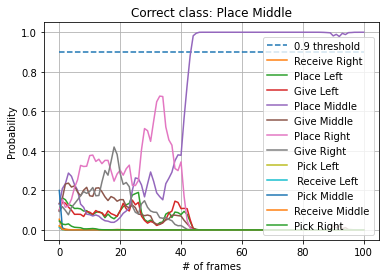

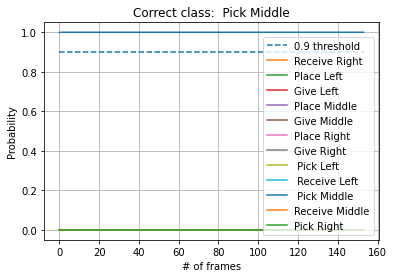

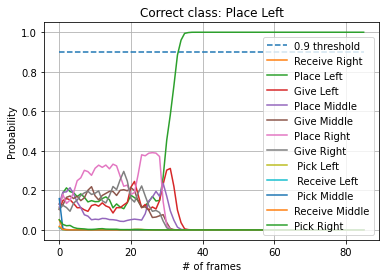

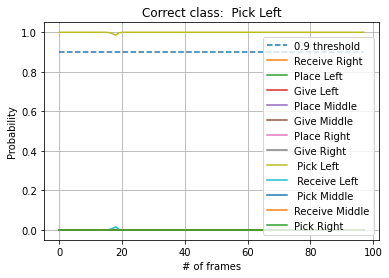

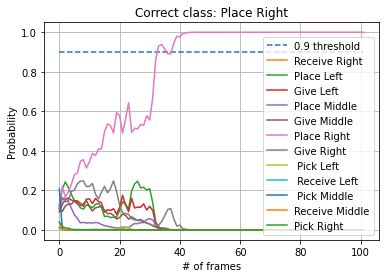

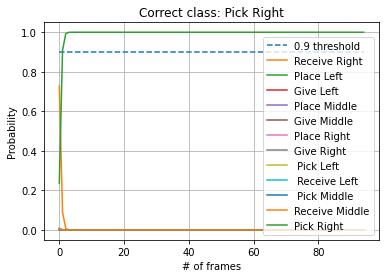

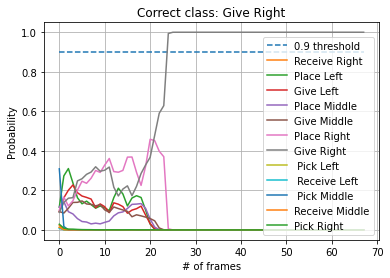

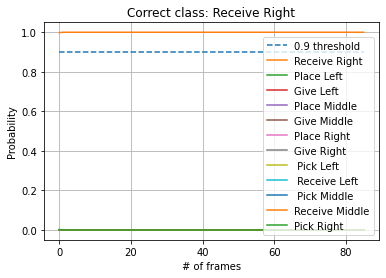

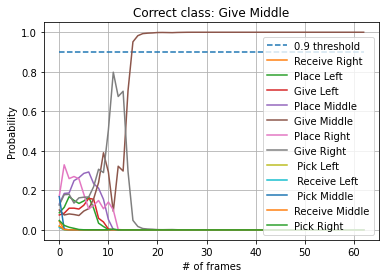

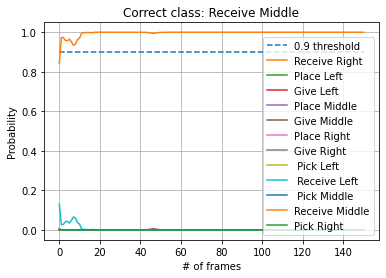

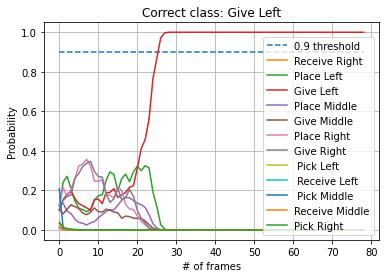

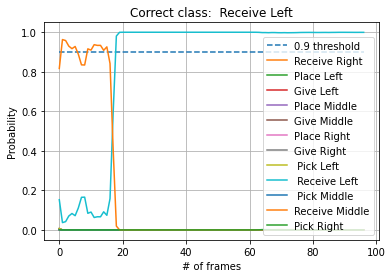

In [ ]:
import matplotlib.pyplot as plt
index = [0,1,2,3,4,5,6,7,8,9,22,23]
for i in range(12):
  idx = index.pop(0)
  head, body,ball, trg = dataset.__getitem__(idx) 
  output, pred = get_prediction(head,body,ball, model2)
  pred = pred.cpu().detach().numpy()
  frame = np.arange(len(trg))
  prob = np.repeat(0.9,len(trg))
  plt.plot(frame, prob, linestyle = '--', label='0.9 threshold')
  for j in range(12):
    o = pred[j,:]
    plt.plot(frame,o, label=str(actions[j]))
  plt.grid(True)
  plt.xlabel('# of frames')
  plt.ylabel('Probability')
  plt.title('Correct class: '+str(actions[trg[0]]))
  plt.legend(loc=4)
  plt.show()


Run the cell to get graphs based on different hyper-parameters

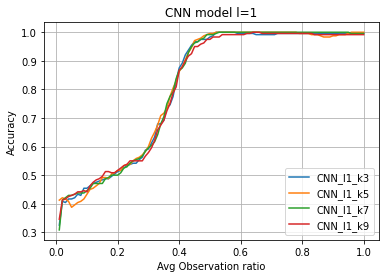

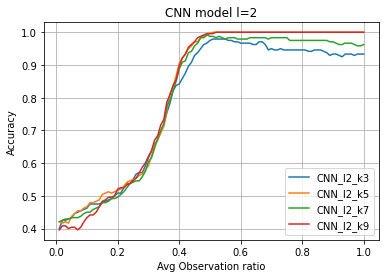

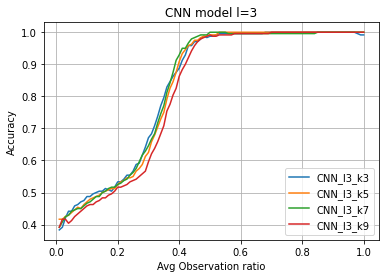

In [ ]:
import matplotlib.pyplot as plt
ratios = np.arange(0.01,1.01,0.01)
# for k in range(3,11,2):
for l in range(1,4):
    # for l in range(1,4):
    for k in range(3,11,2):
        acc2 = np.load('/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_end_epoch.npy')
        plt.plot(ratios,acc2, label='CNN_l'+str(l)+'_k'+str(k))
    plt.grid(True)
    plt.xlabel('Avg Observation ratio')
    plt.ylabel('Accuracy')
    plt.title('CNN model l='+str(l))
    plt.legend(loc=4)
    plt.show()



# CNN vs LSTM graph

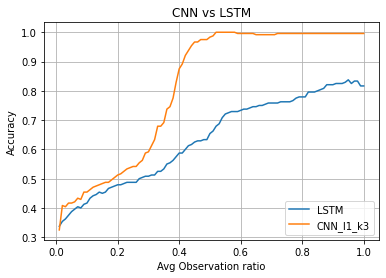

In [7]:

ratios = np.arange(0.01,1.01,0.01)
l, k = 1,3
acc1 = np.load('/content/DLSTM_epoch_end_final.npy')
plt.plot(ratios,acc1, label='LSTM')
acc2 = np.load('/content/drive/My Drive/CNN_l'+str(l)+'_k'+str(k)+'_end_epoch.npy')
plt.plot(ratios,acc2, label='CNN_l'+str(l)+'_k'+str(k))
plt.grid(True)
plt.xlabel('Avg Observation ratio')
plt.ylabel('Accuracy')
plt.title('CNN vs LSTM')
plt.legend(loc=4)
plt.show()

